## 导入实验所需模块

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import platform
import sys
from six.moves import cPickle as pickle

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization, ReLU
from keras.layers import Activation
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model, np_utils
from tensorflow.keras import backend as K

Using TensorFlow backend.


## 自定义加载数据函数

In [4]:
def load_batch(fpath, label_key='labels'):
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [5]:
def load_data(ROOT):
    path = ROOT
    num_train_samples = 50000 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8') 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath) 
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1) 
    return (x_train, y_train), (x_test, y_test)

## 加载数据

In [6]:
(X_train, y_train), (X_test, y_test) = load_data('./dataset')

## 查看数据形状、类型

In [7]:
print(X_train.shape,y_train.shape)
print(type(X_train),type(y_train))

(50000, 32, 32, 3) (50000, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## 查看前十张图片

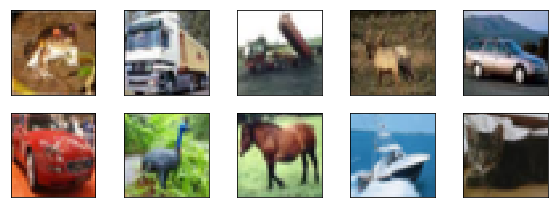

In [8]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 选择所有的汽车图片

In [9]:
idx = np.where(y_train[:]==1)[0]
X_train = X_train[idx,::]

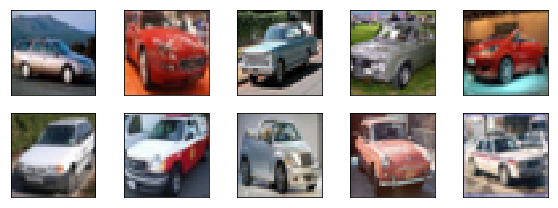

In [10]:
fig = plt.figure(figsize=(8,3))
for i in range(0, 10):
    plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    plt.imshow(X_train[i])
    
plt.tight_layout()

## 图片预处理

In [12]:
num_classes = 10
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = c.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# 将标签转化为热编码形式
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# 将图像每一位像素设定在[-1,1]之间（为了使用tanh函数）
X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

## 定义生成器

In [13]:
# 噪声z初始维度
latent_dim = 100
#权重初始化为均值为0，标准差为0.02的正态分布
init = initializers.RandomNormal(stddev=0.02)

# 开始建立生成网络
generator = Sequential()

# 第一层使用全连接，其余层使用微步幅度卷积、批处理
# 最后一层使用tanhx激活函数，其余层均使用RuLu激活函数

# 1x100 ——> 2x2x512
generator.add(Dense(2*2*512, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(Reshape((2, 2, 512)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 2x2x512 ——> 4x4x256
generator.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 4x4x256 ——> 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 8x8x128 ——> 16x16x64
generator.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))
# 6x16x64 ——> 32x32x3
generator.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same'))
#generator.add(BatchNormalization())
generator.add(Activation('tanh'))

Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# 查看判别网络细节
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2048)              206848    
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 512)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 2, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2, 2, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0         
__________

## 定义判别器

In [15]:
# 判别器输入图像的形状
img_shape = X_train[0].shape

# 开始建立判别网络
discriminator = Sequential()
#使用步幅卷积代替池化层
#除最后一层使用使用sigmoid激活函数，其余层均使用LeakyRelu函数作为激活函数

# 32x32x3 ——> 16x16x64
discriminator.add(Conv2D(64, kernel_size=5, strides=2, padding='same',
                         input_shape=(img_shape), kernel_initializer=init))
#discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 16x16x64 ——> 8x8x128
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 8x8x128 ——> 4x4x256
discriminator.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 4x4x256 ——> 2x2x512
discriminator.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))
# 2x2x512 ——> 2048
discriminator.add(Flatten())
# 输出使用FC，为一维
discriminator.add(Dense(1, activation='sigmoid'))

In [16]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 256)         1024      
__________

## 判别器优化器，形成最优的D

In [17]:
# 优化器:Adam优化器，学习率0.0002，动量0.5
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

## 连接生成器和判别器，构建DCGAN网络

In [18]:
discriminator.trainable = False
z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

In [19]:
# DCGAN网络细节
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 3)         4516739   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 4312193   
Total params: 8,828,932
Trainable params: 4,514,819
Non-trainable params: 4,314,113
_________________________________________________________________


## DCGAN优化器，形成最优的G

In [20]:
d_g.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

## 训练

Instructions for updating:
Use tf.cast instead.
epoch = 1/300, d_loss=0.383, g_loss=5.132                                                                                                                       


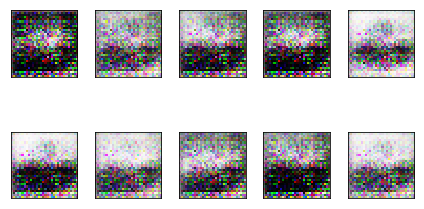

epoch = 2/300, d_loss=0.267, g_loss=1.017                                                                                                                      
epoch = 3/300, d_loss=0.264, g_loss=1.446                                                                                                                      
epoch = 4/300, d_loss=0.199, g_loss=0.583                                                                                                                       
epoch = 5/300, d_loss=1.590, g_loss=8.781                                                                                                                       
epoch = 6/300, d_loss=0.261, g_loss=3.328                                                                                                                       
epoch = 7/300, d_loss=0.236, g_loss=4.897                                                                                                                                                            

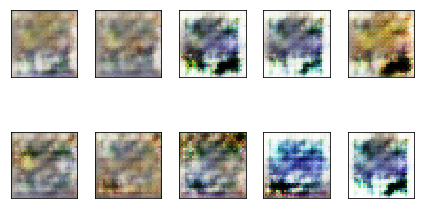

epoch = 12/300, d_loss=0.169, g_loss=0.050                                                                                                                      
epoch = 13/300, d_loss=0.232, g_loss=2.645                                                                                                                       
epoch = 14/300, d_loss=0.183, g_loss=2.249                                                                                                                       
epoch = 15/300, d_loss=0.426, g_loss=7.491                                                                                                                      
epoch = 16/300, d_loss=0.195, g_loss=1.377                                                                                                                      
epoch = 17/300, d_loss=0.168, g_loss=0.200                                                                                                                      
epoch = 18/300, d_loss=0.285, g_

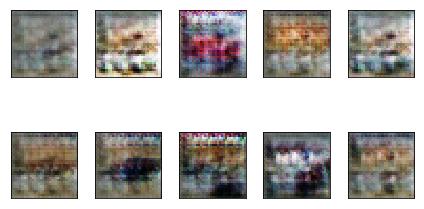

epoch = 22/300, d_loss=0.289, g_loss=2.061                                                                                                                      
epoch = 23/300, d_loss=0.174, g_loss=0.113                                                                                                                      
epoch = 24/300, d_loss=0.230, g_loss=0.580                                                                                                                       
epoch = 25/300, d_loss=0.178, g_loss=0.071                                                                                                                      
epoch = 26/300, d_loss=0.741, g_loss=9.202                                                                                                                      
epoch = 27/300, d_loss=0.173, g_loss=0.072                                                                                                                      
epoch = 28/300, d_loss=0.205, g_l

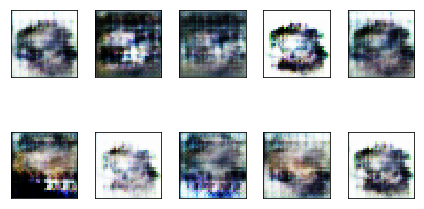

epoch = 32/300, d_loss=0.181, g_loss=0.096                                                                                                                      
epoch = 33/300, d_loss=0.363, g_loss=1.695                                                                                                                      
epoch = 34/300, d_loss=0.189, g_loss=0.268                                                                                                                      
epoch = 35/300, d_loss=0.217, g_loss=7.559                                                                                                                       
epoch = 36/300, d_loss=0.168, g_loss=0.696                                                                                                                      
epoch = 37/300, d_loss=0.184, g_loss=0.598                                                                                                                      
epoch = 38/300, d_loss=0.167, g_l

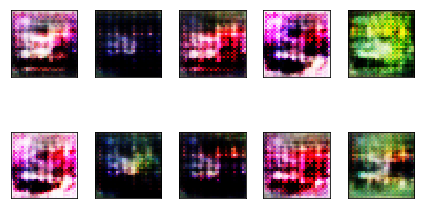

epoch = 42/300, d_loss=0.170, g_loss=0.097                                                                                                                      
epoch = 43/300, d_loss=0.177, g_loss=0.230                                                                                                                      
epoch = 44/300, d_loss=0.180, g_loss=0.680                                                                                                                      
epoch = 45/300, d_loss=0.183, g_loss=4.203                                                                                                                      
epoch = 46/300, d_loss=0.197, g_loss=0.405                                                                                                                      
epoch = 47/300, d_loss=0.555, g_loss=4.236                                                                                                                       
epoch = 48/300, d_loss=0.299, g_l

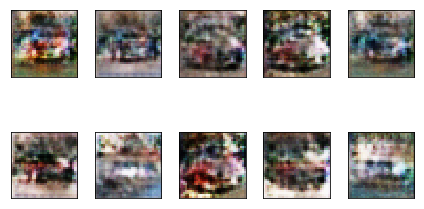

epoch = 52/300, d_loss=0.240, g_loss=1.823                                                                                                                      
epoch = 53/300, d_loss=0.200, g_loss=4.575                                                                                                                      
epoch = 54/300, d_loss=0.185, g_loss=5.515                                                                                                                       
epoch = 55/300, d_loss=0.207, g_loss=4.779                                                                                                                      
epoch = 56/300, d_loss=0.194, g_loss=4.564                                                                                                                      
epoch = 57/300, d_loss=0.194, g_loss=4.831                                                                                                                      
epoch = 58/300, d_loss=0.302, g_l

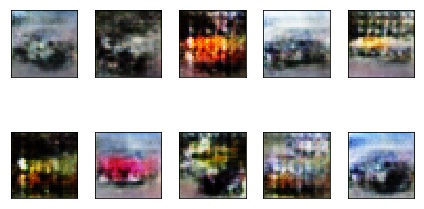

epoch = 62/300, d_loss=0.188, g_loss=3.790                                                                                                                       
epoch = 63/300, d_loss=0.188, g_loss=3.115                                                                                                                      
epoch = 64/300, d_loss=0.270, g_loss=5.343                                                                                                                       
epoch = 65/300, d_loss=0.347, g_loss=3.540                                                                                                                       
epoch = 66/300, d_loss=0.189, g_loss=5.487                                                                                                                      
epoch = 67/300, d_loss=0.183, g_loss=6.861                                                                                                                      
epoch = 68/300, d_loss=0.182, g

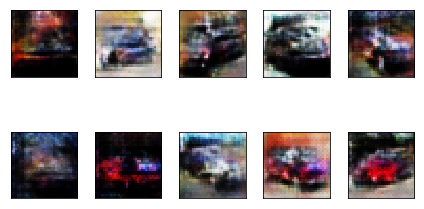

epoch = 72/300, d_loss=0.302, g_loss=4.049                                                                                                                      
epoch = 73/300, d_loss=0.190, g_loss=5.907                                                                                                                       
epoch = 74/300, d_loss=0.287, g_loss=3.599                                                                                                                      
epoch = 75/300, d_loss=0.200, g_loss=4.381                                                                                                                      
epoch = 76/300, d_loss=0.208, g_loss=4.088                                                                                                                      
epoch = 77/300, d_loss=0.201, g_loss=4.623                                                                                                                       
epoch = 78/300, d_loss=0.219, g_

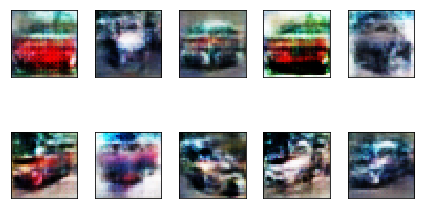

epoch = 82/300, d_loss=0.203, g_loss=3.091                                                                                                                       
epoch = 83/300, d_loss=0.179, g_loss=4.686                                                                                                                      
epoch = 84/300, d_loss=0.218, g_loss=3.369                                                                                                                      
epoch = 85/300, d_loss=0.228, g_loss=3.521                                                                                                                      
epoch = 86/300, d_loss=0.256, g_loss=3.163                                                                                                                       
epoch = 87/300, d_loss=0.183, g_loss=4.590                                                                                                                      
epoch = 88/300, d_loss=0.183, g_

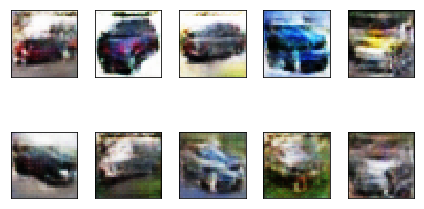

epoch = 92/300, d_loss=0.179, g_loss=5.369                                                                                                                      
epoch = 93/300, d_loss=0.195, g_loss=4.192                                                                                                                      
epoch = 94/300, d_loss=0.327, g_loss=5.132                                                                                                                       
epoch = 95/300, d_loss=0.222, g_loss=4.019                                                                                                                      
epoch = 96/300, d_loss=0.176, g_loss=8.941                                                                                                                       
epoch = 97/300, d_loss=0.179, g_loss=10.590                                                                                                                      
epoch = 98/300, d_loss=0.178, g

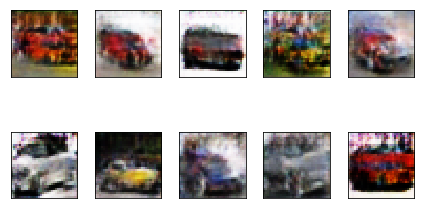

epoch = 102/300, d_loss=0.180, g_loss=4.821                                                                                                                       
epoch = 103/300, d_loss=0.176, g_loss=5.669                                                                                                                      
epoch = 104/300, d_loss=0.176, g_loss=6.680                                                                                                                      
epoch = 105/300, d_loss=0.192, g_loss=3.927                                                                                                                       
epoch = 106/300, d_loss=0.178, g_loss=5.047                                                                                                                       
epoch = 107/300, d_loss=0.194, g_loss=4.778                                                                                                                      
epoch = 108/300, d_loss=0

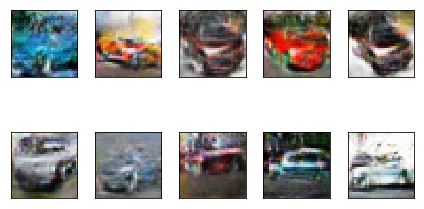

epoch = 112/300, d_loss=0.205, g_loss=4.649                                                                                                                      
epoch = 113/300, d_loss=0.180, g_loss=9.887                                                                                                                       
epoch = 114/300, d_loss=0.190, g_loss=5.261                                                                                                                      
epoch = 115/300, d_loss=0.309, g_loss=5.696                                                                                                                      
epoch = 116/300, d_loss=0.178, g_loss=6.775                                                                                                                       
epoch = 117/300, d_loss=0.283, g_loss=5.120                                                                                                                       
epoch = 118/300, d_loss=0

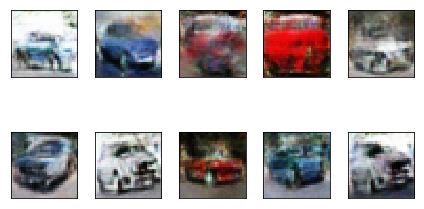

epoch = 122/300, d_loss=0.177, g_loss=4.771                                                                                                                      
epoch = 123/300, d_loss=0.183, g_loss=5.209                                                                                                                       
epoch = 124/300, d_loss=0.177, g_loss=5.505                                                                                                                       
epoch = 125/300, d_loss=0.219, g_loss=6.399                                                                                                                                                                                                                         
epoch = 126/300, d_loss=0.451, g_loss=6.160                                                                                                                       
epoch = 127/300, d_loss=0.199, g_loss=4.848                                             

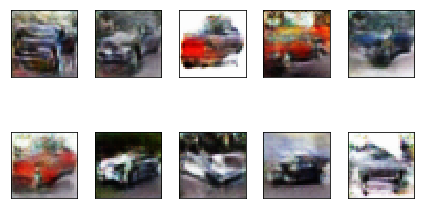

epoch = 132/300, d_loss=0.188, g_loss=5.145                                                                                                                       
epoch = 133/300, d_loss=0.177, g_loss=4.970                                                                                                                       
epoch = 134/300, d_loss=0.200, g_loss=5.056                                                                                                                       
epoch = 135/300, d_loss=0.175, g_loss=5.754                                                                                                                      
epoch = 136/300, d_loss=0.174, g_loss=5.767                                                                                                                       
epoch = 137/300, d_loss=0.301, g_loss=4.780                                                                                                                      
epoch = 138/300, d_loss=

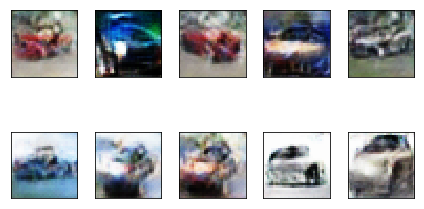

epoch = 142/300, d_loss=0.174, g_loss=5.219                                                                                                                      
epoch = 143/300, d_loss=0.177, g_loss=6.628                                                                                                                      
epoch = 144/300, d_loss=0.866, g_loss=2.366                                                                                                                       
epoch = 145/300, d_loss=0.180, g_loss=6.143                                                                                                                      
epoch = 146/300, d_loss=0.200, g_loss=8.999                                                                                                                      
epoch = 147/300, d_loss=0.197, g_loss=5.033                                                                                                                       
epoch = 148/300, d_loss=0.

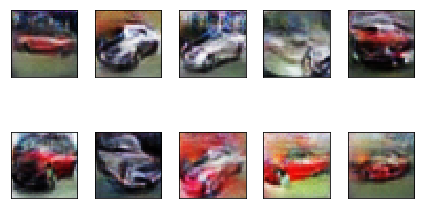

epoch = 152/300, d_loss=0.177, g_loss=4.542                                                                                                                      
epoch = 153/300, d_loss=0.300, g_loss=2.412                                                                                                                      
epoch = 154/300, d_loss=0.224, g_loss=5.928                                                                                                                      
epoch = 155/300, d_loss=0.194, g_loss=7.076                                                                                                                      
epoch = 156/300, d_loss=0.169, g_loss=6.883                                                                                                                       
epoch = 157/300, d_loss=0.172, g_loss=7.485                                                                                                                       
epoch = 158/300, d_loss=0.

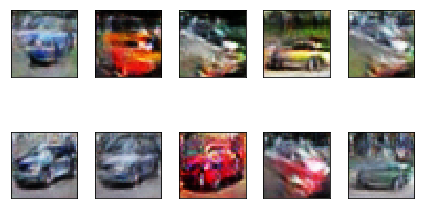

epoch = 162/300, d_loss=0.179, g_loss=5.467                                                                                                                       
epoch = 163/300, d_loss=0.175, g_loss=5.109                                                                                                                      
epoch = 164/300, d_loss=0.185, g_loss=6.199                                                                                                                       
epoch = 165/300, d_loss=0.198, g_loss=4.774                                                                                                                      
epoch = 166/300, d_loss=0.223, g_loss=5.679                                                                                                                      
epoch = 167/300, d_loss=0.221, g_loss=3.555                                                                                                                      
epoch = 168/300, d_loss=0.

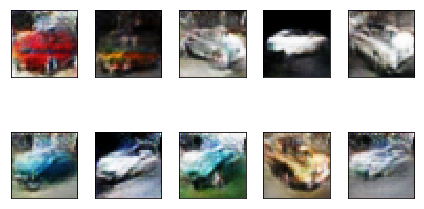

epoch = 172/300, d_loss=0.184, g_loss=5.165                                                                                                                      
epoch = 173/300, d_loss=0.191, g_loss=7.371                                                                                                                      
epoch = 174/300, d_loss=0.188, g_loss=4.485                                                                                                                       
epoch = 175/300, d_loss=0.186, g_loss=4.255                                                                                                                      
epoch = 176/300, d_loss=0.184, g_loss=5.330                                                                                                                       
epoch = 177/300, d_loss=0.188, g_loss=5.198                                                                                                                      
epoch = 178/300, d_loss=0.

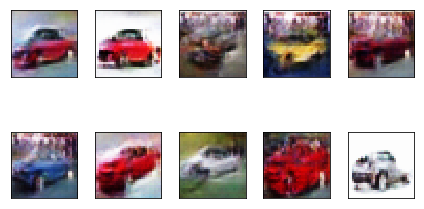

epoch = 182/300, d_loss=0.175, g_loss=5.777                                                                                                                       
epoch = 183/300, d_loss=0.172, g_loss=6.482                                                                                                                      
epoch = 184/300, d_loss=0.177, g_loss=6.479                                                                                                                       
epoch = 185/300, d_loss=0.205, g_loss=4.381                                                                                                                      
epoch = 186/300, d_loss=0.240, g_loss=4.084                                                                                                                      
epoch = 187/300, d_loss=0.188, g_loss=6.139                                                                                                                      
epoch = 188/300, d_loss=0.

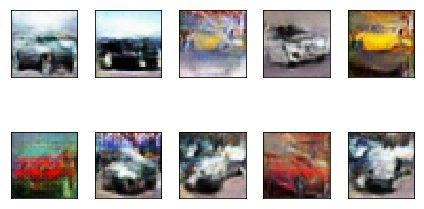

epoch = 192/300, d_loss=0.175, g_loss=5.800                                                                                                                      
epoch = 193/300, d_loss=0.201, g_loss=4.915                                                                                                                      
epoch = 194/300, d_loss=0.253, g_loss=4.595                                                                                                                      
epoch = 195/300, d_loss=0.180, g_loss=6.984                                                                                                                      
epoch = 196/300, d_loss=0.216, g_loss=3.761                                                                                                                      
epoch = 197/300, d_loss=0.190, g_loss=5.099                                                                                                                       
epoch = 198/300, d_loss=0.2

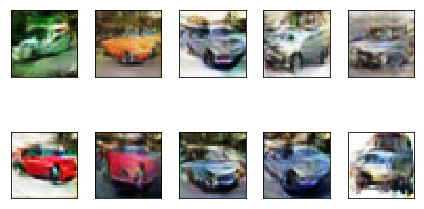

epoch = 202/300, d_loss=0.183, g_loss=5.805                                                                                                                      
epoch = 203/300, d_loss=0.254, g_loss=5.829                                                                                                                       
epoch = 204/300, d_loss=0.172, g_loss=5.269                                                                                                                       
epoch = 205/300, d_loss=0.177, g_loss=5.097                                                                                                                      
epoch = 206/300, d_loss=0.177, g_loss=6.441                                                                                                                       
epoch = 207/300, d_loss=0.179, g_loss=5.731                                                                                                                      
epoch = 208/300, d_loss=0

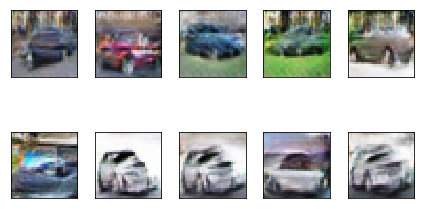

epoch = 212/300, d_loss=0.180, g_loss=5.629                                                                                                                      
epoch = 213/300, d_loss=0.188, g_loss=4.847                                                                                                                      
epoch = 214/300, d_loss=0.177, g_loss=4.900                                                                                                                      
epoch = 215/300, d_loss=0.180, g_loss=5.267                                                                                                                       
epoch = 216/300, d_loss=0.172, g_loss=5.544                                                                                                                      
epoch = 217/300, d_loss=0.196, g_loss=4.982                                                                                                                      
epoch = 218/300, d_loss=0.1

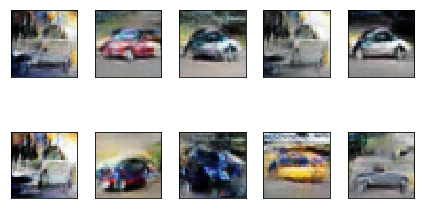

epoch = 222/300, d_loss=0.172, g_loss=6.575                                                                                                                      
epoch = 223/300, d_loss=0.185, g_loss=6.531                                                                                                                      
epoch = 224/300, d_loss=0.185, g_loss=6.544                                                                                                                      
epoch = 225/300, d_loss=0.172, g_loss=5.287                                                                                                                      
epoch = 226/300, d_loss=0.202, g_loss=6.434                                                                                                                      
epoch = 227/300, d_loss=0.196, g_loss=4.271                                                                                                                      
epoch = 228/300, d_loss=0.17

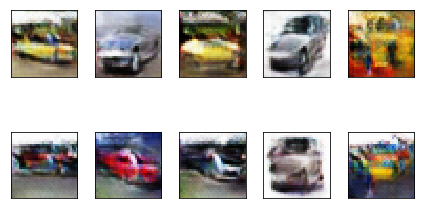

epoch = 232/300, d_loss=0.201, g_loss=4.916                                                                                                                      
epoch = 233/300, d_loss=0.168, g_loss=5.837                                                                                                                      
epoch = 234/300, d_loss=0.170, g_loss=6.634                                                                                                                      
epoch = 235/300, d_loss=0.171, g_loss=5.964                                                                                                                       
epoch = 236/300, d_loss=0.332, g_loss=6.807                                                                                                                       
epoch = 237/300, d_loss=0.187, g_loss=5.498                                                                                                                       
epoch = 238/300, d_loss=0

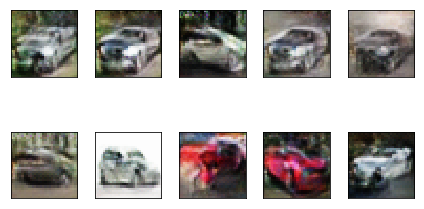

epoch = 242/300, d_loss=0.175, g_loss=5.162                                                                                                                       
epoch = 243/300, d_loss=0.181, g_loss=6.104                                                                                                                      
epoch = 244/300, d_loss=0.173, g_loss=7.386                                                                                                                      
epoch = 245/300, d_loss=0.174, g_loss=8.377                                                                                                                      
epoch = 246/300, d_loss=0.177, g_loss=6.104                                                                                                                       
epoch = 247/300, d_loss=0.194, g_loss=6.389                                                                                                                      
epoch = 248/300, d_loss=0.

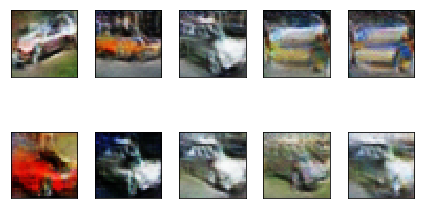

epoch = 252/300, d_loss=0.199, g_loss=6.269                                                                                                                      
epoch = 253/300, d_loss=0.178, g_loss=6.264                                                                                                                       
epoch = 254/300, d_loss=0.172, g_loss=6.008                                                                                                                      
epoch = 255/300, d_loss=0.187, g_loss=5.840                                                                                                                       
epoch = 256/300, d_loss=0.183, g_loss=4.801                                                                                                                       
epoch = 257/300, d_loss=0.182, g_loss=5.521                                                                                                                      
epoch = 258/300, d_loss=0

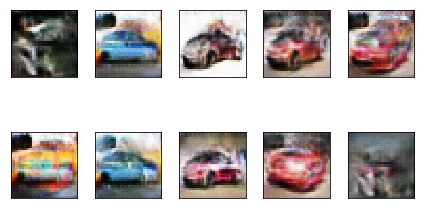

epoch = 262/300, d_loss=0.168, g_loss=6.185                                                                                                                       
epoch = 263/300, d_loss=0.194, g_loss=6.515                                                                                                                       
epoch = 264/300, d_loss=0.182, g_loss=5.466                                                                                                                      
epoch = 265/300, d_loss=0.174, g_loss=5.416                                                                                                                      
epoch = 266/300, d_loss=0.188, g_loss=5.273                                                                                                                       
epoch = 267/300, d_loss=0.191, g_loss=4.660                                                                                                                                                

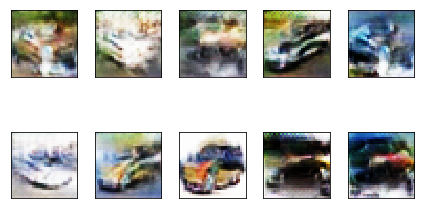

epoch = 272/300, d_loss=0.169, g_loss=6.185                                                                                                                      
epoch = 273/300, d_loss=0.170, g_loss=5.622                                                                                                                       
epoch = 274/300, d_loss=0.169, g_loss=6.194                                                                                                                       
epoch = 275/300, d_loss=0.168, g_loss=5.441                                                                                                                      
epoch = 276/300, d_loss=0.172, g_loss=5.909                                                                                                                      
epoch = 277/300, d_loss=0.173, g_loss=8.403                                                                                                                       
epoch = 278/300, d_loss=0

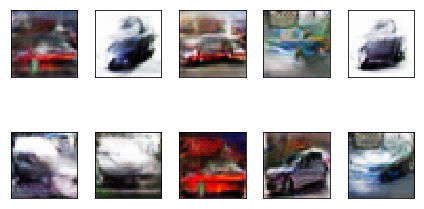

epoch = 282/300, d_loss=0.184, g_loss=6.343                                                                                                                       
epoch = 283/300, d_loss=0.181, g_loss=5.409                                                                                                                      
epoch = 284/300, d_loss=0.176, g_loss=5.407                                                                                                                       
epoch = 285/300, d_loss=0.167, g_loss=5.550                                                                                                                      
epoch = 286/300, d_loss=0.173, g_loss=6.111                                                                                                                       
epoch = 287/300, d_loss=0.178, g_loss=6.578                                                                                                                      
epoch = 288/300, d_loss=0

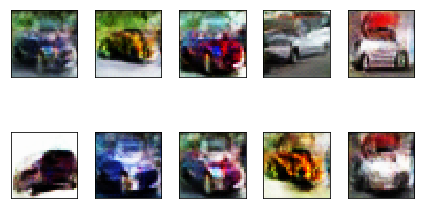

epoch = 292/300, d_loss=0.192, g_loss=5.774                                                                                                                       
epoch = 293/300, d_loss=0.266, g_loss=5.723                                                                                                                       
epoch = 294/300, d_loss=0.179, g_loss=5.499                                                                                                                       
epoch = 295/300, d_loss=0.170, g_loss=6.735                                                                                                                       
epoch = 296/300, d_loss=0.182, g_loss=5.962                                                                                                                       
epoch = 297/300, d_loss=0.176, g_loss=10.118                                                                                                                      
epoch = 298/300, d_los

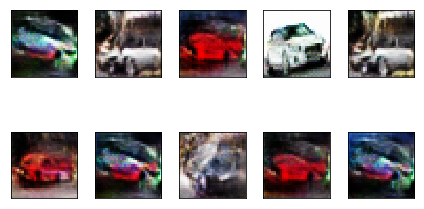

In [21]:
# 训练轮次
epochs = 300
# 每批数量
batch_size = 32
# 查阅资料发现设置smooth参数会有较好的效果
smooth = 0.1
# G训练时使得D(G(z))为real
# D训练时使得D(G(z))为fake，D(X_train[i])为real
real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))
# 用来存储生成器和判别器的损失
d_loss = []
g_loss = []
# 开始训练
for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):        
        
        # 训练判别器
        discriminator.trainable = True        
        # 输入真实数据，期望结果为real
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch,y=real * (1 - smooth))       
        # 输入生成器生成的数据，期望结果为fake
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict_on_batch(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
        # 判别器损失，之后与生成器损失放在同一图中，便于观察乘以系数 0.5
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # 训练DCGAN（即生成器）
        discriminator.trainable = False
        # 输入生成器生成的数据，期望结果为real
        g_loss_batch = d_g.train_on_batch(x=z, y=real)

        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(((x_fake[k] + 1)* 127).astype(np.uint8))

        plt.tight_layout()
        plt.show()

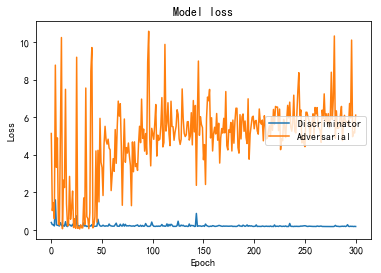

In [22]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()